# Running LLM Web Research Agents at Scale

The `agent_map()` function runs an LLM web research agent on every row of a dataframe. Each agent can search the web, read pages, and synthesize findings into structured output. This notebook demonstrates running 10,000 agents in parallel, where each row may require a different amount of research to resolve.

## Example: Researching 10,000 Drug Products

This example takes a dataset of 10,000 drug product entries (trade name, ingredient, applicant, strength, dosage form) and determines each product's current FDA regulatory status. Determining regulatory status requires researching each product individually against FDA databases, Orange Book listings, Federal Register notices, and other sources. Some products have straightforward histories while others have complex timelines involving tentative approvals, voluntary withdrawals, or transitions between marketed and not marketed status.

This run achieved a 99.97% success rate (9,997 of 10,000 rows returned results). For evals on agent accuracy, see [evals.futuresearch.ai](https://evals.futuresearch.ai/) or our [papers](https://futuresearch.ai/research).

## Load Data

In [ ]:
from dotenv import load_dotenv
import pandas as pd
from pydantic import BaseModel, Field
from everyrow import create_session
from everyrow.ops import agent_map

pd.set_option("display.max_colwidth", None)


load_dotenv()

In [2]:
input_df = pd.read_csv("regulatory_status_results.csv", usecols=["row_id", "trade_name", "ingredient", "applicant", "strength", "dosage_form"])
print(f"{len(input_df):,} drug products")
print(f"Columns: {list(input_df.columns)}")
input_df.head(5)

10,000 drug products
Columns: ['row_id', 'trade_name', 'ingredient', 'applicant', 'strength', 'dosage_form']


,row_id,trade_name,ingredient,applicant,strength,dosage_form
0,3,TREPROSTINIL,TREPROSTINIL,ALEMBIC GLOBAL,5MG/ML,"INJECTABLE;INTRAVENOUS, SUBCUTANEOUS"
1,4,TREPROSINIL,TREPROSTINIL,ALEMBIC GLOBAL,5MG/ML,"INJECTABLE;INTRAVENOUS, SUBCUTANEOUS"
2,5,TREPRROSTINIL,TREPROSTINIL,ALEMBIC GLOBAL,5MG/ML,"INJECTABLE;INTRAVENOUS, SUBCUTANEOUS"
3,10,ZIDOVUDINE,ZIDOVUDINE,CIPLA LTD,100MG,CAPSULE;ORAL
4,11,ZIDOVUINE,ZIDOVUDINE,CIPLA LTD,100MG,CAPSULE;ORAL


## Define Response Model and Task

Each agent researches a drug product's regulatory status using its trade name, ingredient, and dosage form. The `regulatory_status` field is constrained to a fixed set of allowed values.

In [3]:
from enum import Enum


class RegulatoryStatus(str, Enum):
    NDA = "FDA approved (NDA)"
    ANDA = "FDA approved (ANDA \u2013 generic)"
    TENTATIVE = "Tentative approval"
    DISCONTINUED = "Discontinued (not withdrawn for safety)"
    WITHDRAWN = "Withdrawn for safety reasons"
    NOT_MARKETED = "Approved but currently not marketed"
    UNDER_REVIEW = "Under FDA review"
    EUA = "Emergency Use Authorization (EUA)"
    NOT_APPROVED = "Not FDA approved (compounded / ex-US only)"


class DrugRegulatoryResult(BaseModel):
    regulatory_status: RegulatoryStatus = Field(
        description="The current FDA regulatory status of this drug product."
    )


AGENT_TASK = """Research the current regulatory status based on its trade name, ingredient, and dosage form.

Allowed Values for regulatory_status:
FDA approved (NDA)
FDA approved (ANDA \u2013 generic)
Tentative approval
Discontinued (not withdrawn for safety)
Withdrawn for safety reasons
Approved but currently not marketed
Under FDA review
Emergency Use Authorization (EUA)
Not FDA approved (compounded / ex-US only)

NOTHING ELSE."""

## Run Agent Map

Send all 10k rows to `agent_map()`. Each row gets its own agent that researches the product's regulatory history, checking FDA Orange Book listings, approval databases, Federal Register notices, and other sources.

In [ ]:
async with create_session(name="Drug Regulatory Status Research") as session:
    print(f"Session URL: {session.get_url()}\n")
    result = await agent_map(
        task=AGENT_TASK,
        input=input_df,
        response_model=DrugRegulatoryResult,
        session=session,
    )

### Cost

Running 10,000 agents cost $1.17k, averaging around $0.11 per row.

## Inspecting Results

Load the results CSV and analyze the regulatory status classifications.

In [15]:
results_df = pd.read_csv("regulatory_status_results.csv")
print(f"Total rows: {len(results_df):,}")
print(f"Rows with results: {results_df['regulatory_status'].notna().sum():,}")
print(f"Failed rows: {results_df['regulatory_status'].isna().sum()}")
results_df.head(2)

Total rows: 10,000
Rows with results: 9,997
Failed rows: 3


,row_id,trade_name,ingredient,applicant,strength,dosage_form,regulatory_status,research
0,3,TREPROSTINIL,TREPROSTINIL,ALEMBIC GLOBAL,5MG/ML,"INJECTABLE;INTRAVENOUS, SUBCUTANEOUS",FDA approved (ANDA – generic),"Alembic Global Holding SA received final FDA approval for its Abbreviated New Drug Application (ANDA) 211574 for Treprostinil Injection (5 mg/mL and other strengths) on February 11, 2021 [https://alembicpharmaceuticals.com/webfiles/media/2020-2021/Press-Release-AGH-USFDA-Final-Approval-Treprostinil-Injection-February-2021.pdf]. The product is a generic version of the reference listed drug, Remodulin. According to recent FDA Orange Book listings and the Prescription Drug Product List (verified through 2024 and 2025 cumulative supplements and change lists), the product remains in the active section with a therapeutic equivalence (TE) code of AP, indicating it is currently approved and marketed as a generic [https://www.fda.gov/media/183457/download, https://www.thefdalawblog.com/wp-content/uploads/2021/11/obcs_2021_10.pdf]. While some strengths of Treprostinil from other manufacturers (e.g., PH Health, Sandoz) have been moved to the Discontinued section, Alembic Global's 5 mg/mL strength continues to be listed as an approved prescription drug product."
1,4,TREPROSINIL,TREPROSTINIL,ALEMBIC GLOBAL,5MG/ML,"INJECTABLE;INTRAVENOUS, SUBCUTANEOUS",FDA approved (ANDA – generic),"Alembic Global's Treprostinil Injection (5 mg/mL, injectable dosage form) received final FDA approval under Abbreviated New Drug Application (ANDA) 211574 on February 11, 2021 [70c9fa, ee558e]. The product is currently listed in the active 'Prescription Drug Product List' of the FDA Orange Book, which contains approved drug products that are currently marketed [70c9fa]. This is further supported by the NDC Directory, where the 5 mg/mL strength (NDC 62332-517) is listed with an 'Active' status [ndclist.com, dailymed.nlm.nih.gov]. The 'TREPROSINIL' trade name provided in the request appears to be a typographical variation of the ingredient 'Treprostinil,' as Alembic Global markets the product as generic 'Treprostinil Injection' [expresspharma.in, 70c9fa]. Prior to final approval, the application received tentative approval in September 2020 [medicaldialogues.in, pharmatutor.org]. Currently, there is no evidence that this product has been moved to the FDA's Discontinued Drug Product List [70c9fa]."


In [5]:
status_counts = results_df["regulatory_status"].value_counts()
status_pct = (results_df["regulatory_status"].value_counts(normalize=True) * 100).round(1)

summary = pd.DataFrame({"count": status_counts, "percent": status_pct})
print("Regulatory Status Breakdown")
print("=" * 50)
summary

Regulatory Status Breakdown


,count,percent
regulatory_status,,
Discontinued (not withdrawn for safety),5320,53.2
FDA approved (ANDA – generic),3527,35.3
FDA approved (NDA),956,9.6
Withdrawn for safety reasons,78,0.8
Approved but currently not marketed,71,0.7
Not FDA approved (compounded / ex-US only),30,0.3
Tentative approval,10,0.1
FDA approve (NDA),2,0.0
Discontinued (not withdrawn for safety) **Federal Register determination that product was not discontinued or withdrawn for safety or effectiveness reasons**,1,0.0


/var/folders/lj/6bz8lstx4ql8j728_7861wn80000gn/T/ipykernel_77061/2086085218.py:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


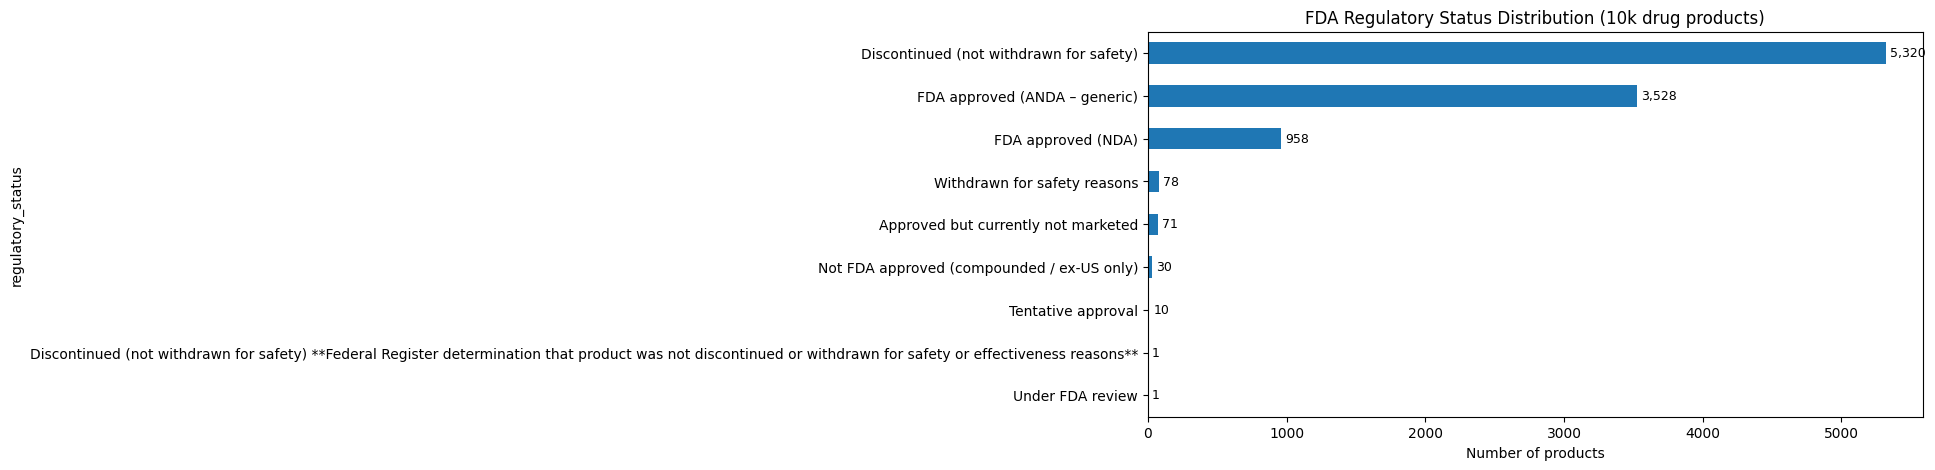

In [5]:
import matplotlib.pyplot as plt

# Normalize near-duplicate labels before plotting
normalize_map = {
    "FDA approve (NDA)": "FDA approved (NDA)",
    "FDA approved (ANDA - generic)": "FDA approved (ANDA \u2013 generic)",
}
plot_df = results_df.copy()
plot_df["regulatory_status"] = plot_df["regulatory_status"].replace(normalize_map)

counts = plot_df["regulatory_status"].value_counts()

fig, ax = plt.subplots(figsize=(10, 5))
counts.plot.barh(ax=ax)
ax.set_xlabel("Number of products")
ax.set_title("FDA Regulatory Status Distribution (10k drug products)")
ax.invert_yaxis()
for i, v in enumerate(counts.values):
    ax.text(v + 30, i, f"{v:,}", va="center", fontsize=9)
plt.tight_layout()
plt.show()

### Exploring by Status Category

In [14]:
# Products withdrawn for safety reasons
withdrawn = results_df[results_df["regulatory_status"] == "Withdrawn for safety reasons"]
print(f"Withdrawn for safety: {len(withdrawn)} products")
withdrawn[["trade_name", "ingredient", "dosage_form", "research"]].sample(min(2, len(withdrawn)), random_state=42)

Withdrawn for safety: 78 products


,trade_name,ingredient,dosage_form,research
5216,TROVAN,TROVAFLOXACIN MESYLATE,TABLET;ORAL,"TROVAN (Trovafloxacin Mesylate) tablets, 200mg (NDA 020759), was originally approved by the FDA on December 18, 1997. Following reports of serious liver injury (hepatotoxicity) and death, the FDA restricted its use in 1999 and the product was subsequently discontinued by Pfizer. In 2006, the FDA officially withdrew the approval of the NDA for TROVAN tablets (71 FR 34940). Crucially, in a 2014 Federal Register notice (79 FR 37748), the FDA included 'Trovafloxacin mesylate: All drug products containing trovafloxacin mesylate' in the list of drug products that have been withdrawn or removed from the market for reasons of safety or effectiveness, which prevents them from being used in compounding under sections 503A and 503B of the Federal Food, Drug, and Cosmetic Act. This determination confirms the status as 'Withdrawn for safety reasons'. Sources: Federal Register 79 FR 37748 (https://www.federalregister.gov/documents/2014/07/02/2014-15371/additions-and-modifications-to-the-list-of-drug-products-that-have-been-withdrawn-or-removed-from); FDA Drugs@FDA database for NDA 020759; EMA Public Statement on Trovan (https://www.ema.europa.eu/en/news/public-statement-trovan-trovan-iv-turvel-turvel-iv-trovafloxacin-alatrofloxacin-recommendation-suspend-marketing-authorisation-european-union)."
42,PERMAX,PERGOLIDE MESYLATE,TABLET;ORAL,"The drug product PERMAX (pergolide mesylate) EQ 1MG BASE, oral tablet, was voluntarily withdrawn from the U.S. market on March 29, 2007, by its manufacturers, including Valeant Pharmaceuticals, due to its association with a high risk of heart valve damage (valvular heart disease). The FDA formally determined in the Federal Register (79 FR 37747, July 2, 2014) that pergolide mesylate was withdrawn for reasons of safety or effectiveness and added it to the list of products that may not be used for compounding under sections 503A or 503B of the Federal Food, Drug, and Cosmetic Act. This determination is also codified in 21 CFR 216.24. Sources: FDA Public Health Advisory 2007 (https://www.fda.gov/drugs/postmarket-drug-safety-information-patients-and-providers/pergolide-marketed-permax-information); Federal Register Notice 79 FR 37747 (https://www.federalregister.gov/documents/2014/07/02/2014-15371/additions-and-modifications-to-the-list-of-drug-products-that-have-been-withdrawn-or-removed-from); 21 CFR 216.24 (https://www.ecfr.gov/current/title-21/chapter-I/subchapter-C/part-216/subpart-B/section-216.24)."


In [12]:
# Discontinued products (not for safety)
discontinued = results_df[results_df["regulatory_status"] == "Discontinued (not withdrawn for safety)"]
print(f"Discontinued (not for safety): {len(discontinued):,} products")
discontinued[["trade_name", "ingredient", "applicant", "research"]].sample(2, random_state=42)

Discontinued (not for safety): 5,320 products


,trade_name,ingredient,applicant,research
3473,LAMOTRIGINE,LAMOTRIGINE,RUBICON RESEARCH,"Lamotrigine Extended-Release Tablets (50 mg) was approved under ANDA 202887 on June 17, 2013, with Rubicon Research Private Ltd as the original applicant (https://www.drugfuture.com/fda/drugview/202887). According to FDA Orange Book records and supplements, the product was subsequently transferred to Handa Pharms LLC via an Applicant Holder Name change (CAHN) in January 2014 (https://www.fda.gov/media/103359/download#:~:text=A%20202887%20002%20Jun%2017%2C%202013%20Jan%20CAHN). As a result of this transfer, the listing for Rubicon Research was moved to the Discontinued Drug Product List (https://thefdalawblog.com/wp-content/uploads/2020/06/CS08-August-2013.pdf). There is no record of the product being withdrawn for safety or effectiveness reasons. Although the ANDA remains active under a different applicant, the specific regulatory status for Rubicon Research as the applicant is Discontinued (not withdrawn for safety)."
9488,ABITREXATE,METHOTREXATE SODIUM,ABIC,"The drug product ABITREXATE (methotrexate sodium), EQ 50MG BASE/VIAL, INJECTABLE;INJECTION, was approved by the FDA under ANDA 089354 on July 17, 1987, with ABIC (a subsidiary of Teva) as the applicant. According to FDA database records and industry databases mirroring the Orange Book, the product is currently listed as discontinued. Specifically, research findings indicate that ABITREXATE was not withdrawn from the market for safety or effectiveness reasons, as noted in various regulatory databases and legal exhibits (e.g., USPTO Medac Exhibit 2026, DrugFuture FDA database mirror). Sources: DrugFuture FDA Database (A089354) at drugfuture.com/fda/drug/abitrexate.html; USPTO Medac Exhibit 2026 (Frontier Therapeutics v. Medac) at ptacts.uspto.gov; PharmaCompass Drug Product Composition (Abitrexate)."


In [13]:
# Currently approved products (NDA + ANDA)
approved = results_df[results_df["regulatory_status"].isin(["FDA approved (NDA)", "FDA approved (ANDA \u2013 generic)"])]
print(f"Currently FDA approved: {len(approved):,} products ({len(approved)/len(results_df)*100:.1f}%)")
print(f"  NDA (brand): {(results_df['regulatory_status'] == 'FDA approved (NDA)').sum():,}")
print(f"  ANDA (generic): {(results_df['regulatory_status'] == 'FDA approved (ANDA \u2013 generic)').sum():,}")
approved[["trade_name", "ingredient", "applicant", "dosage_form", "research"]].sample(2, random_state=42)

Currently FDA approved: 4,483 products (44.8%)
  NDA (brand): 956
  ANDA (generic): 3,527


,trade_name,ingredient,applicant,dosage_form,research
366,PANTOPRAZOLE NA,PANTOPRAZOLE SODIUM,DEXCEL,"FOR SUSPENSION, DELAYED RELEASE;ORAL","The regulatory status for Pantoprazole Sodium for Suspension, Delayed Release; Oral (EQ 40mg Base) by Dexcel is 'FDA approved (ANDA – generic)'. This is based on Abbreviated New Drug Application (ANDA) 216247, which was granted final approval by the FDA on June 16, 2023 [0ba36d]. The product is listed in the FDA Orange Book Prescription Drug Product List, indicating it is an approved generic drug product available for prescription use [0ba36d]. Furthermore, the June 2023 Orange Book Cumulative Supplement explicitly notes that this product was moved into the Prescription Drug Product List from the Discontinued Section due to a change in marketing status, confirming its active approved status [0ba36d]. Current market availability is further supported by drug listing records on DailyMed for the product manufactured for Edenbridge Pharmaceuticals LLC (doing business as Dexcel Pharma USA). Although some sources use the shorthand 'PANTOPRAZOLE NA' for the sodium salt, the official FDA records for ANDA 216247 identify the drug by its ingredient name, Pantoprazole Sodium."
8848,PRAMIPEXOLE DIHYDROCHLORIDE,PRAMIPEXOLE DIHYDROCHLORIDE,NOVAST LABS,"TABLET, EXTENDED RELEASE;ORAL","The product Pramipexole Dihydrochloride Tablet, Extended Release; Oral, 3mg, manufactured by Novast Labs, was approved by the FDA under Abbreviated New Drug Application (ANDA) 213444 on February 3, 2022. According to the FDA Orange Book January 2022 Changes List, the product (Product No. 005 for the 3mg strength) was added to the Prescription Drug Product List as a new addition (NEWA). This listing in the Prescription Drug Product List, rather than the Discontinued Drug Product List, signifies that the product is approved and marketed as a generic version of the reference listed drug (Mirapex ER). No records indicate withdrawal for safety or effectiveness; on the contrary, regulatory records from early 2022 show the product being moved from the discontinued section back to the active marketing list due to a change in status. Sources: FDA Orange Book January 2022 Changes List (https://www.fda.gov/media/156148/download), Orange Book Cumulative Supplement 2 February 2022, and DailyMed entry for ANDA 213444 (https://dailymed.nlm.nih.gov/dailymed/lookup.cfm?setid=1d2b1d2c-ae22-424a-bad7-ce24a817b042)."
